# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [ ]:
!conda install pandas-datareader

In [1]:
import pandas as pd
import pandas_datareader.data as web

In [2]:
web.DataReader?

In [3]:
names=['TSLA','AMZN','COKE','NVDA']
start='01-01-2018'
end='12-31-2021'
def get_close(names,start,end):
    return web.DataReader(names,'yahoo',start,end)['Adj Close']
data=get_close(names,start,end)
data.head()

Symbols,TSLA,AMZN,COKE,NVDA
Date,,,,
2018-01-02,64.106003,1189.010010,207.655319,49.372391
2018-01-03,63.450001,1204.199951,205.414474,52.621780
2018-01-04,62.924000,1209.589966,201.984344,52.899166
2018-01-05,63.316002,1229.140015,198.534576,53.347439
2018-01-08,67.281998,1246.869995,205.365326,54.982048


<AxesSubplot:xlabel='Date'>

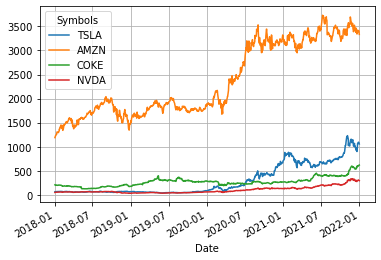

In [4]:
data.plot(grid=True)

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [5]:
R=data.pct_change().dropna()
R.head()

Symbols,TSLA,AMZN,COKE,NVDA
Date,,,,
2018-01-03,-0.010233,0.012775,-0.010791,0.065814
2018-01-04,-0.008290,0.004476,-0.016699,0.005271
2018-01-05,0.006230,0.016163,-0.017079,0.008474
2018-01-08,0.062638,0.014425,0.034406,0.030641
2018-01-09,-0.008085,0.004676,-0.016511,-0.000270


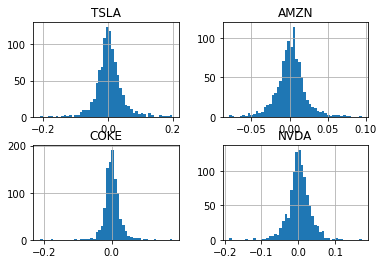

In [6]:
H=R.hist(bins=50)

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [7]:
me,std=R.mean(),R.std()
me

Symbols
TSLA    0.003623
AMZN    0.001217
COKE    0.001389
NVDA    0.002246
dtype: float64

In [8]:
std

Symbols
TSLA    0.041012
AMZN    0.019644
COKE    0.024595
NVDA    0.030617
dtype: float64

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2018, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2019 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [16]:
N=10000 # Número de escenarios a simular
d=31    # Número de días a simular

In [1]:
pd.date_range?

Object `pd.date_range` not found.


In [11]:
pd.date_range('01-01-2022',periods=5)

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05'],
              dtype='datetime64[ns]', freq='D')

In [13]:
import numpy as np

In [14]:
np.random.normal?

In [15]:
np.random.normal(1,1,(5,10)) # 5 días y 10 escenarios

array([[ 0.86266158,  1.76847235,  0.05350933,  1.34491479, -0.23924887,
        -0.3654857 , -1.0860146 ,  0.22611835,  1.14325801, -0.10899228],
       [ 1.01939616,  1.12184874,  0.66131221, -0.29915748,  2.33225592,
         1.07277065,  0.98119804,  1.91669279, -0.32134869,  2.112212  ],
       [-0.0438099 ,  1.38670138,  0.83532344,  2.73730675,  0.28235102,
         1.54505591,  0.14424652,  1.16632357,  0.82006452,  0.69898054],
       [ 1.52589718,  0.10315231,  1.97519444,  1.06313708,  1.7167378 ,
         1.45102479,  0.6186264 ,  1.71031729,  0.98069608,  1.67844815],
       [ 1.42131683,  2.14630866,  0.29963976,  1.42461039,  1.26897956,
        -0.51935108,  0.20747493, -0.24330163,  2.08660249, -0.00399495]])

In [17]:
def simR(me,std,start,d,N):
    fechas=pd.date_range(start,periods=d)
    return pd.DataFrame(index=fechas,data=np.random.normal(me,std,(d,N)))
rTSLA=simR(me['TSLA'],std['TSLA'],'01-01-2022',d,N)
rAMZN=simR(me['AMZN'],std['AMZN'],'01-01-2022',d,N)
rCOKE=simR(me['COKE'],std['COKE'],'01-01-2022',d,N)
rNVDA=simR(me['NVDA'],std['NVDA'],'01-01-2022',d,N)

In [18]:
rTSLA.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2022-01-01,-0.021055,-0.005210,0.042366,-0.039171,-0.058678,0.010234,-0.044141,-0.052557,0.024974,-0.022360,...,-0.014984,0.024860,-0.012061,-0.005511,0.038717,-0.012874,-0.022302,-0.034747,-0.045159,0.020132
2022-01-02,0.049486,-0.017731,-0.066200,-0.048303,0.013608,-0.029678,0.068952,0.009093,0.049121,-0.008285,...,-0.020442,-0.016511,-0.036068,0.011196,0.003579,0.034590,-0.031338,0.008221,0.021606,-0.022153
2022-01-03,0.001084,-0.046172,0.025424,-0.011231,0.014256,-0.004912,0.037163,-0.007147,-0.028117,0.096533,...,0.083005,-0.035501,0.039343,0.054483,0.000847,0.036265,-0.016920,-0.013891,0.039249,0.000033


## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

In [19]:
data.iloc[-1]

Symbols
TSLA    1056.780029
AMZN    3334.340088
COKE     618.925354
NVDA     294.059875
Name: 2021-12-31 00:00:00, dtype: float64

In [20]:
TSLA=data['TSLA'].iloc[-1]*(rTSLA+1).cumprod()
TSLA.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2022-01-01,1034.529420,1051.273809,1101.551669,1015.384872,994.769894,1067.594603,1010.132177,1001.238662,1083.171747,1033.150190,...,1040.945756,1083.051884,1044.034585,1050.956125,1097.694873,1043.175277,1033.211956,1020.060161,1009.057149,1078.055318
2022-01-02,1085.723911,1032.633704,1028.629388,966.339099,1008.306417,1035.910490,1079.782439,1010.343068,1136.378570,1024.590300,...,1019.666877,1065.169389,1006.378610,1062.722602,1101.624045,1079.258999,1000.833087,1028.445752,1030.859212,1054.173351
2022-01-03,1086.900668,984.955170,1054.781189,955.485934,1022.681219,1030.822415,1119.910855,1003.121806,1104.427357,1123.497153,...,1104.303989,1027.354515,1045.972249,1120.622536,1102.557419,1118.397969,983.898687,1014.159787,1071.319509,1054.208477


In [21]:
AMZN=data['AMZN'].iloc[-1]*(rAMZN+1).cumprod()
COKE=data['COKE'].iloc[-1]*(rCOKE+1).cumprod()
NVDA=data['NVDA'].iloc[-1]*(rNVDA+1).cumprod()

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [24]:
import matplotlib.pyplot as plt

In [31]:
UTSLA=data['TSLA'][-1]*1.1   # Umbral para TSLA

In [32]:
UTSLA

1162.4580322265626

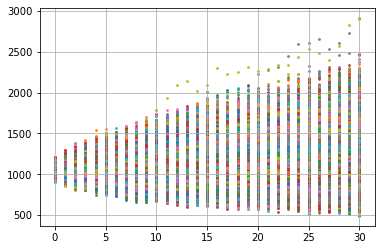

In [26]:
for i in range(N):
    plt.scatter(range(31),TSLA[i],s=3)
plt.grid()

In [38]:
%matplotlib inline

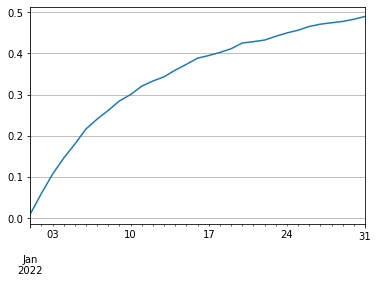

In [40]:
BTSLA=TSLA>UTSLA         # Variable de Bernoulli
PTSLA=BTSLA.mean(axis=1) # Probabilidad de que supere el Umbral
PTSLA.plot(grid=True)
plt.show()

<AxesSubplot:>

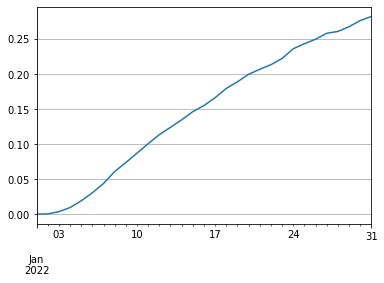

In [34]:
UAMZN=data['AMZN'][-1]*1.1   # Umbral
BAMZN=AMZN>UAMZN        # Variable de Bernoulli
PAMZN=BAMZN.mean(axis=1) # Probabilidad
PAMZN.plot(grid=True)

<AxesSubplot:>

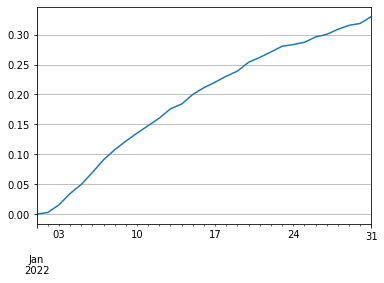

In [35]:
UCOKE=data['COKE'][-1]*1.1   # Umbral
BCOKE=COKE>UCOKE        # Variable de Bernoulli
PCOKE=BCOKE.mean(axis=1) # Probabilidad
PCOKE.plot(grid=True)

<AxesSubplot:>

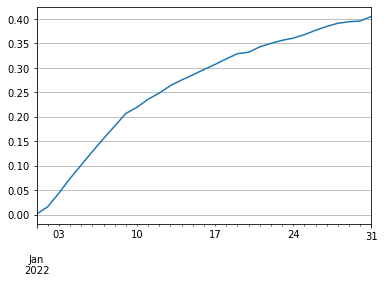

In [36]:
UNVDA=data['NVDA'][-1]*1.1   # Umbral
BNVDA=NVDA>UNVDA        # Variable de Bernoulli
PNVDA=BNVDA.mean(axis=1) # Probabilidad
PNVDA.plot(grid=True)

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.